# CS4035 - Cyber Data Analytics
## Lab 2 - PCA/Regression task

## Group Number : 21

## Student 2
### Name : Michał Okoń
### ID :

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import ccf

In [2]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab2-PCA-Regression.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 203


## 0. Data Loading

#### Loading into pandas dataframe

In [3]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [99]:
# Excluding the time frame and the target variable and backup signals
relevant_signals = ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401',
                    'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
                    'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'MV101', 'P101', 'MV201', 'P203', 'P205', 'MV301',
                    'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'UV401', 'P501', 'P602']
relevant_train_data_df = train_data_df[relevant_signals]
relevant_train_data_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV301,MV302,MV303,MV304,P301,P302,P402,UV401,P501,P602
Id,,,,,,,,,,,,,,,,,,,,,
0,2.470294,261.5804,244.3284,8.190080,306.1010,2.471278,20.79839,2.235275,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
1,2.457163,261.1879,244.3284,8.190080,306.1010,2.468587,20.79839,2.234507,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
2,2.439548,260.9131,244.3284,8.190080,306.1010,2.467305,20.84320,2.233354,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
3,2.428338,260.2850,244.3284,8.190080,306.1010,2.466536,20.84320,2.233354,327.2799,0.000,...,1,2,1,1,2,1,1,1,1,1
4,2.424815,259.8925,244.4245,8.190080,306.1010,2.466536,20.84320,2.233354,327.1597,0.000,...,1,2,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496795,2.460366,523.0430,262.0161,8.396437,328.5055,2.442316,19.74838,2.212087,955.8046,148.808,...,1,2,1,1,1,2,2,2,2,1
496796,2.448836,522.9645,262.0161,8.396437,328.5055,2.442316,19.74838,2.210037,955.8847,148.808,...,1,2,1,1,1,2,2,2,2,1
496797,2.434744,522.8860,262.0161,8.396437,328.6337,2.444879,19.74838,2.207731,955.9648,148.808,...,1,2,1,1,1,2,2,2,2,1


In [5]:
test_data_df

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Id,,,,,,,,,,,,,,,,,,,,,
224959,31/12/2015 12:29:19 AM,2.612177,517.6261,2,2,1,192.2263,8.530376,324.2758,2.443597,...,0.306825,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224960,31/12/2015 12:29:20 AM,2.612177,517.7831,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224961,31/12/2015 12:29:21 AM,2.594562,518.2149,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,249.9840,0.816967,188.4613,0.0,1,1,1
224962,31/12/2015 12:29:22 AM,2.577907,518.7645,2,2,1,192.2263,8.531017,324.2758,2.442060,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
224963,31/12/2015 12:29:23 AM,2.562854,519.1177,2,2,1,192.2263,8.531017,324.2758,2.441419,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.1535,0.865024,189.0220,0.0,1,1,1
449915,2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1
449916,2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1


## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

Main functions used to perform the PCA and plot the residuals.

In [177]:
def get_pca_residuals(df, components=None):
    total_residuals = []
    if components is None:
        component_range = range(1, len(df.columns))
    else:
        component_range = components
    for n_components in component_range:
        pca = PCA(n_components=n_components)
        pca.fit(df)
        # Calculate residuals
        residuals = calculate_residuals(df, pca)
        total_residuals.append(residuals)
    return total_residuals


def plot_pca_residuals(residuals, components, start_index=0, true_labels=None, predicted_labels=None):
    plt.clf()
    x = np.arange(start_index, len(residuals[0]))
    for i, residual in enumerate(residuals):
        plt.plot(x, residual[start_index:], label=f'{components[i]}')
    if true_labels is not None:
        plt.vlines(true_labels, ymin=-2, ymax=2, colors='r', linestyles='dashed')
    if predicted_labels is not None:
        plt.vlines(predicted_labels, ymin=-1, ymax=1, colors='b', linestyles='dashed')
    plt.legend()
    plt.show()

def calculate_residuals(df, pca):
    return np.sum(np.abs(df - pca.inverse_transform(pca.transform(df))), axis=1)

Perform the residual analysis.

In [48]:
components = np.arange(1, len(relevant_train_data_df.columns))

In [49]:
residuals = get_pca_residuals(relevant_train_data_df)

In [91]:
partial_components1 = [1, 2, 5]
partial_residuals1 = get_pca_residuals(relevant_train_data_df, components=partial_components1)

In [173]:
partial_components2 = [10, 15, 20]
partial_residuals2 = get_pca_residuals(relevant_train_data_df, components=partial_components2)

In [138]:
partial_components3 = [25, 30, 35]
partial_residuals3 = get_pca_residuals(relevant_train_data_df, components=partial_components3)

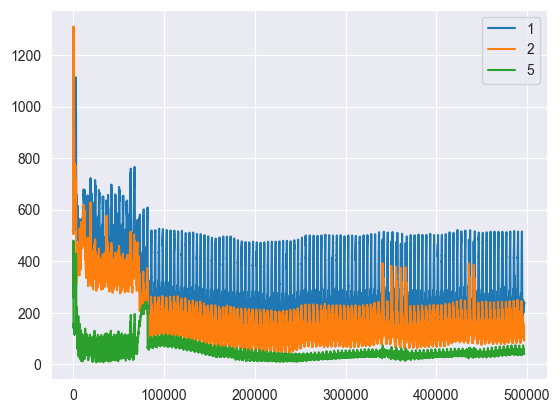

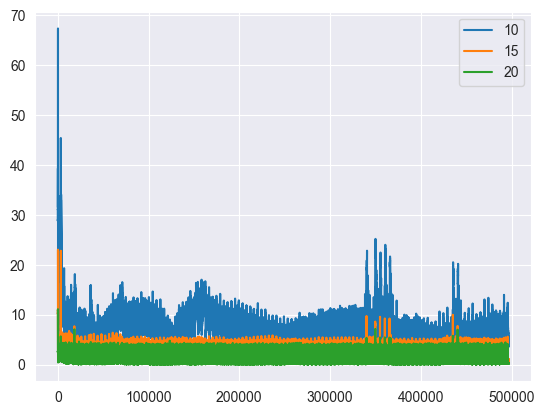

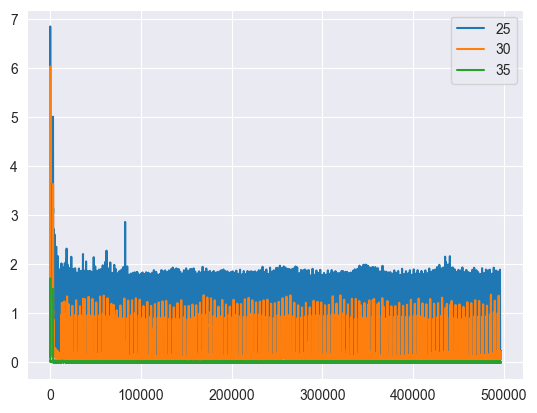

In [174]:
plot_pca_residuals(partial_residuals1, partial_components1, start_index=0)
plot_pca_residuals(partial_residuals2, partial_components2, start_index=0)
plot_pca_residuals(partial_residuals3, partial_components3, start_index=0)

In [36]:
# plot_pca_residuals(residuals, start_index=50000)

Analyzing the residuals in the test and validation sets.

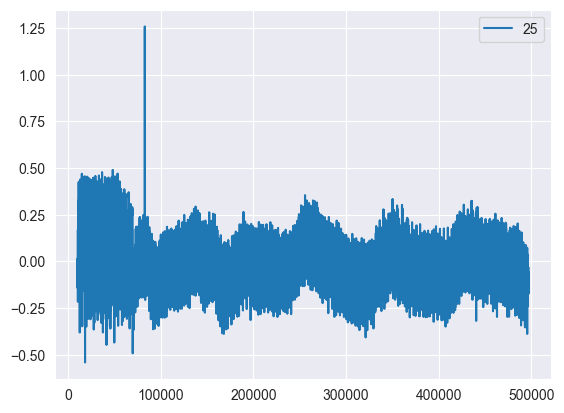

In [171]:
final_components = 25 # 25 good
start_index = 10000
final_pca = PCA(n_components=final_components)
final_pca.fit(relevant_train_data_df)
train_data_pca = final_pca.transform(relevant_train_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_train_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

Plotting residuals from the test set.

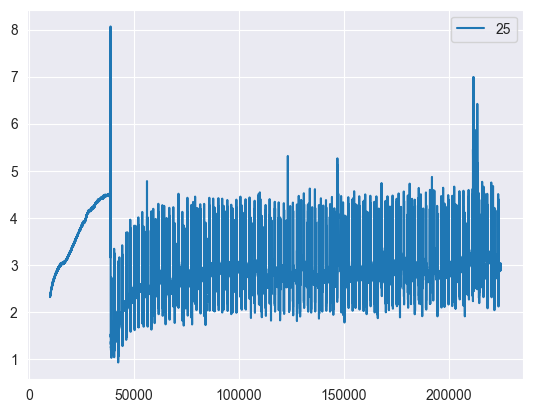

In [170]:
relevant_test_data_df = test_data_df[relevant_signals]

test_data_pca = final_pca.transform(relevant_test_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_test_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

Plotting residuals from the validation dataset and marking anomalies (red dashed vertical lines). As can be seen, some anomalies are properly detected.

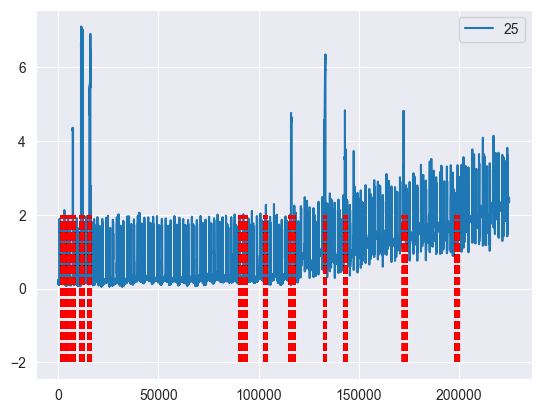

In [168]:
relevant_validation_data_df = val_data_df[relevant_signals]
validation_data_pca = final_pca.transform(relevant_validation_data_df)
# Calculate residuals
validation_residuals = calculate_residuals(relevant_validation_data_df, final_pca)

# Get indices of anomalies
anomaly_indices = np.where((val_data_df['Label'].to_numpy() == 1))[0]
plot_pca_residuals([validation_residuals], components=[final_components], start_index=0, true_labels=anomaly_indices)

Defining the allowed range for each of the signal which is set to be (1.5 * smallest_signal_residual, 1.5 * largest_signal_residual) to provide some safety margin. If the residual of a signal is out of this range, then the signal is considered an anomaly.

In [191]:
def calculate_thresholds(residuals, range_multiplier=1.5):
    return residuals.max() * range_multiplier

start_signal = 10000
trimmed_train_data_df = relevant_train_data_df.iloc[start_signal:, :]
train_residuals = calculate_residuals(trimmed_train_data_df, final_pca)
threshold = calculate_thresholds(train_residuals, range_multiplier=1.5)
print(threshold)

4.301609497302962


In [192]:
print(validation_residuals)

Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64


In [196]:
def find_anomalies_in_residuals(residuals, threshold):
    """
    Returns the set containing indices of anomalies in the residuals.
    """
    anomalies_indices = set()
    # Return indices where the residual is out of the allowed range using numpy
    for i, residual in enumerate(residuals):
        if residual > threshold:
            anomalies_indices.add(i)
    return anomalies_indices


predicted_anomalies = find_anomalies_in_residuals(validation_residuals, threshold)


In [197]:
plot_pca_residuals([validation_residuals], start_index=0, true_labels=anomaly_indices,
                   predicted_labels=predicted_anomalies)

TypeError: plot_pca_residuals() missing 1 required positional argument: 'components'

Calculate metrics for the PCA model.

In [203]:
# Calculate the number of true positives, false positives, true negatives and false negatives
def calculate_statistics(predicted_anomalies, true_anomalies):
    true_positives = len(set(predicted_anomalies).intersection(set(true_anomalies)))
    false_positives = len(set(predicted_anomalies).difference(set(true_anomalies)))
    true_negatives = len(
        set(np.arange(len(validation_residuals.index))).difference(set(predicted_anomalies).union(set(true_anomalies))))
    false_negatives = len(set(true_anomalies).difference(set(predicted_anomalies)))
    return true_positives, false_positives, true_negatives, false_negatives


tp, fp, tn, fn = calculate_statistics(predicted_anomalies, anomaly_indices)
print(f"True positives: {tp}, False positives: {fp}, True negatives: {tn}, False negatives: {fn}")


def calculate_metrics(tp, fp, tn, fn):
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    return accuracy, precision, recall, f1_score


accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}")


True positives: 2177, False positives: 59, True negatives: 213864, False negatives: 8859
Accuracy: 0.960357220649096, Precision: 0.973613595706619, Recall: 0.19726350126857556, F1 score: 0.3280590717299578


Analyze several thresholds. Turns out that multiplying the max and min values in the train set by 4 gives the best results.

In [206]:
def analyze_thresholds(residuals, true_anomalies, thresholds, range_multipliers):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    for i, threshold in enumerate(thresholds):
        predicted_anomalies = list(find_anomalies_in_residuals(residuals, threshold))
        tp, fp, tn, fn = calculate_statistics(predicted_anomalies, true_anomalies)
        accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        print(
            f"Threshold multiplier: {range_multipliers[i]}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}\n")
    return accuracies, precisions, recalls, f1_scores


threshold_multipliers = np.arange(0.4, 3, 0.2)
thresholds = [calculate_thresholds(train_residuals, range_multiplier=multiplier) for multiplier in
              threshold_multipliers]
accuracies, precisions, recalls, f1_scores = analyze_thresholds(validation_residuals, anomaly_indices, thresholds,
                                                                threshold_multipliers)

Threshold multiplier: 0.4, Accuracy: 0.6667437177441222, Precision: 0.07728012060142024, Recall: 0.5295396882928597, F1 score: 0.1348765823880356

Threshold multiplier: 0.6000000000000001, Accuracy: 0.8455051809440831, Precision: 0.1381319989015348, Recall: 0.41020297209133744, F1 score: 0.20666986235704993

Threshold multiplier: 0.8000000000000002, Accuracy: 0.9539827257411351, Precision: 0.5580448065173116, Recall: 0.2979340340703153, F1 score: 0.38846880907372394

Threshold multiplier: 1.0000000000000002, Accuracy: 0.9637267235362889, Precision: 0.8935413245758074, Recall: 0.2958499456324755, F1 score: 0.4445200816882232

Threshold multiplier: 1.2000000000000002, Accuracy: 0.9642734898359256, Precision: 0.954531676265535, Recall: 0.2853388909025009, F1 score: 0.439344262295082

Threshold multiplier: 1.4000000000000004, Accuracy: 0.9614774247751813, Precision: 0.9683794466403162, Recall: 0.2220007249003262, F1 score: 0.36119711042311664

Threshold multiplier: 1.6000000000000005, Accu

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

### 4a. Print relevant plots and/or metrics to determine the parameters.

### 4b. Plots to study the detected anomalies

### 4c. Analysis and answers to the questions